Plot and summarize MultiNest samples using getdist over multiple datasets. Based on a script Wahid sent me.

In [1]:
# import anaconda3/personal python libraries
# TODO: maybe there's a cleaner way of doing this?
import sys
sys.path.append('/home/tmakinen/anaconda3/envs/bahamas/lib/python3.7/site-packages/')

In [26]:
import numpy as np
import pandas as pd
import getdist
import getdist.plots as pt
import matplotlib.pyplot as plt
plt.style.use('./MNRAS_Style.mplstyle')


from latex_format import latexify
%matplotlib inline


from chainconsumer import ChainConsumer

In [3]:
parameters = [
                #'probs', 
                'alpha', 'beta', 'rx', 
                'rc', 'sigma_res',
              'cstar', 'xstar', 'mstar',
           #   'gc', 'gx', 'gm', 'eps',
              'omegam', 'w', 'h', #, 
            'loglike'
            ]
reweight = [
                #'probs', 
                'alpha', 'beta', 'rx', 
                'rc', 'sigma_res',
              'cstar', 'xstar', 'mstar',
           #   'gc', 'gx', 'gm', 'eps',
              'omegam', 'w', 'h'] #, 
       #     'loglike'


param_plot_limits = {
    'alpha': (.1, .16), 'beta': (2.1, 2.8),
    'rx': (0.8, 1.2), 'rc':(.065, 0.105), 'sigma_res':(0.,0.12),
    'cstar': (-.035, 0.01), 'xstar':(-.5, 0.65), 'mstar':(-19.4, -19.25),
    'omegam': (-.1, 1), 'omegade': (0, 1.2), 'h': (.675, .725), 'w': (-4., 0), 
    'loglike': (-100, 0)
}

param_true_values = {
    'alpha': .13, 'beta': 2.56,
    'rx': 1, 'rc': 0.1, 'sigma_res': 0.1,
    'cstar': 0, 'xstar': 0.0, 'mstar': -19.3,
    'omegam': .3, 'omegade': .7, 'h': .72, 'w': -1.0,
    'loglike': -90
   # 'gc': -0.09669245704226216, 'gx': 0.038, 'gm': -0.5849406042825187, 'eps': 13.254733539684956
}

In [4]:
params_of_interest = ['alpha', 'beta', 
                      'rx', 
                        'rc', 
                      'sigma_res',
                      'cstar', 'xstar','mstar',
                    #  'gc', 'gx', 'gm', 'eps', 
                     'omegam', 'w'
                      
                      #, 'loglike'
                      
                     # 'h'
                        ]
                      
labels_of_interest = ['\\alpha', '\\beta', 
                       'r_x', 'r_c', 
                      '\\sigma_{res}',
                     'c_*', 'x_*', 'M_0',
                     # '\\gamma_c', '\\gamma_x', '\\gamma_m', '\\epsilon', 
                        '\\Omega_m',# '\\Omega_{de}', 
                      'w'
                      #'h', 'log(\\mathscr{L})'
                             ] # for plotting

weight_labels = ['unnormalized', 'easy', 'norm']

# load weighted mean samples

In [5]:
#job_id = '2287722' # bahamas multiple run
job_id = '480995'
n_sims = 10

In [15]:
data = []
norm_dat = []
weight_arr = []
loglikes = []
for i in range(n_sims):
    if i+1 not in [9]:
    #if i+1 not in [12]:
    #data_i = pd.read_csv('/rds/general/user/tmakinen/home/WORK/{}[{}].pbs/post_chains.csv'.format(job_id, i+1), sep=",", header=None)

        data_i = pd.read_csv('/c/Users/lucas/Datasets/posterior_samples/{}_wcdm/run_{}/gibbs_chains/post_chains.csv'.format(job_id, i+1), sep=",", header=None)
        data_i.columns = parameters
        loglikes.append(data_i['loglike'].values[7000:])
        data.append(data_i[params_of_interest][7000:])
    
    # take in normalized params for mean computation
        #norm_i = pd.read_csv('/c/Users/lucas/Datasets/posterior_samples/{}_wcdm/run_{}/gibbs_chains/weighted_post.csv'.format(job_id, i+1), sep=",", header=None)
        #norm_i.columns = reweight
        #norm_dat.append(norm_i[params_of_interest])

    
    # compute weights
        weights = pd.read_csv('/c/Users/lucas/Datasets/posterior_samples/{}_wcdm/run_{}/gibbs_chains/weights.csv'.format(job_id, i+1), header=None)
        w_i = weights.T #.values[0]
        w_i.columns = weight_labels
        weight_arr.append(w_i[1000:]) 

(array([210., 331., 823., 757., 753., 949., 610., 325., 199.,  43.]),
 array([-1.66239807, -1.54461542, -1.42683278, -1.30905013, -1.19126748,
        -1.07348484, -0.95570219, -0.83791954, -0.7201369 , -0.60235425,
        -0.48457161]),
 <a list of 10 Patch objects>)

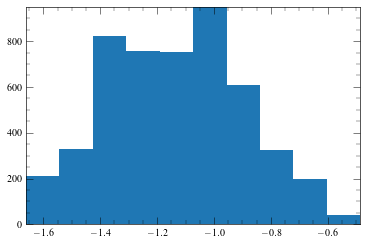

In [27]:
plt.hist(data[0]['w'])

In [10]:
print(1/(np.sum(weight_arr[0]['norm'])**2))

1.041996880123803


In [8]:
n_sims = len(data)
n_sims

9

In [9]:
param_sums = []
for j in range(len(norm_dat)):
    s_j = norm_dat[j].sum()
    param_sums.append(s_j)

tab = pd.concat(param_sums, axis=1)
tab.T.mean()

alpha         0.129895
beta          2.565802
rx            1.017637
rc            0.099761
sigma_res     0.095414
cstar        -0.006221
xstar         0.018329
mstar       -19.313450
omegam        0.329679
w            -1.193517
dtype: float64

In [10]:
norm_dat;

# calculate summary statistics

In [11]:
true_values_of_interest = [param_true_values[label] for label in norm_dat[0].columns.values]
bias = [s_j.sum() - true_values_of_interest for s_j in norm_dat]
var = [data_i.var() for data_i in data]
mse = [var[i] + bias[i]**2 for i in range(n_sims)]

In [12]:
for i in range(n_sims):
    print('Simulation ', i)
    stats = pd.concat([bias[i].rename('bias'), var[i].rename('var'), mse[i].rename('mse')], axis=1)
    print(stats.T)

Simulation  0
         alpha      beta        rx        rc  sigma_res     cstar     xstar  \
bias -0.013548 -0.073372 -0.059640 -0.001540   0.010733 -0.004753  0.008541   
var   0.000096  0.006815  0.001166  0.000013   0.000105  0.000022  0.002024   
mse   0.000280  0.012199  0.004723  0.000015   0.000220  0.000044  0.002097   

         mstar    omegam         w  
bias  0.000069  0.030503 -0.105248  
var   0.000368  0.006114  0.057252  
mse   0.000368  0.007045  0.068329  
Simulation  1
         alpha      beta        rx        rc  sigma_res     cstar     xstar  \
bias -0.008169  0.042432  0.044488 -0.004608  -0.016818 -0.007795  0.006490   
var   0.000085  0.009012  0.001363  0.000013   0.000126  0.000021  0.002481   
mse   0.000151  0.010813  0.003343  0.000034   0.000409  0.000082  0.002523   

         mstar    omegam         w  
bias  0.004613 -0.029057  0.110977  
var   0.000374  0.015350  0.094853  
mse   0.000396  0.016195  0.107169  
Simulation  2
         alpha      beta    

In [13]:
# calculate summary bias and variance
# TODO: do these need to be reweighted?
# TODO: how meaningful are means of each statistic?
means = [s_j.mean() for s_j in norm_dat]
var_of_means = pd.concat(means, axis=1).T.var()
means = pd.concat(means, axis=1).T.mean()
#var_of_means = pd.concat(var_of_means, axis=1).T.mean()
#m_bias = pd.concat(bias, axis=1).mean()

#sigma_err = [m_bias / np.sqrt(np.mean(var) + mean_var[0]) for i in range(len(bias))]

#sigma_err = [bias[i] / np.sqrt(var[i]) for i in range(len(bias))]
mean_bias = pd.concat(bias, axis=1).T.mean()
var_of_bias = pd.concat(bias, axis=1).T.var()
sigma_err = (mean_bias / np.sqrt(var_of_bias + var_of_means))

In [14]:
mean_bias = pd.concat(bias, axis=1).T.mean().to_frame('mean bias')
var_of_bias = pd.concat(bias, axis=1).T.var().to_frame('var of bias')
mean_var = pd.concat(var, axis=1).T.mean().to_frame('mean var')
#mean_sigma_err = pd.concat([sigma_err], axis=1).T.to_frame('sigma err')
mean_sigma_err = sigma_err.to_frame('sigma err')
mean_mse = pd.concat(mse, axis=1).T.mean().to_frame('mean mse')

In [15]:
summarystats = pd.concat([mean_bias, var_of_bias, mean_sigma_err, mean_var, mean_mse], axis=1)
print(summarystats)
#summarystats.to_csv('~/jobs/gibbs_selection/plots{}.csv'.format(job_id))

           mean bias  var of bias  sigma err  mean var  mean mse
alpha      -0.000105     0.000108  -0.010059  0.000075  0.000171
beta        0.005802     0.004491   0.086569  0.007860  0.011886
rx          0.017637     0.001723   0.424963  0.001316  0.003158
rc         -0.000239     0.000012  -0.070405  0.000013  0.000024
sigma_res  -0.004586     0.000083  -0.503428  0.000117  0.000211
cstar      -0.006221     0.000004  -3.184823  0.000023  0.000065
xstar       0.018329     0.000871   0.620981  0.002367  0.003478
mstar      -0.013450     0.000544  -0.576456  0.000493  0.001158
omegam      0.029679     0.007571   0.341097  0.008063  0.015673
w          -0.193517     0.099312  -0.614070  0.109885  0.235611


# create posterior corner plot

In [19]:
n_sims = len(data)

In [20]:
# with weights
mcsamples = [getdist.mcsamples.MCSamples(samples=data[i].values, 
                               names=params_of_interest, 
                               labels=labels_of_interest, weights=weight_arr[i]['norm'].values*10000) for i in range(len(data))]

        
mcsamples.append(getdist.MCSamples(samples=pd.concat(data).values, 
                                   names=params_of_interest, 
                                   labels=labels_of_interest, weights=pd.concat(weight_arr)['norm'].values*10000))

aggregate = getdist.mcsamples.MCSamples(samples=pd.concat(data).values, 
                                   names=params_of_interest, 
                                   labels=labels_of_interest, weights=pd.concat(weight_arr)['norm'].values*10000)
cosmo_params = ['omegam', 'w']
cosmo_labs = ['\\Omega_m', 'w']
cosmo_dat = pd.concat(data)[cosmo_params].values
cosmo = getdist.mcsamples.MCSamples(samples=cosmo_dat, 
                                   names=cosmo_params, 
                                   labels=cosmo_labs, weights=pd.concat(weight_arr)['norm'].values*10000)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [21]:
# plot settings
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

contour_args = []
line_args = []
legend_labels = []

for i in range(n_sims):
    contour_args.append({'color': colors[i]})
    line_args.append({'lw': .75, 'ls': '-', 'color': colors[i]})
    legend_labels.append('sample {}'.format(i+1))

#for i in range(1):
    #contour_args.append({'color': colors[i]})
    #line_args.append({'lw': .75, 'ls': '-', 'color': colors[i]})
    #legend_labels.append('sample 1 vanilla'.format(i+1))

# add in reweighted sample
#contour_args.append({'color': '#ff7f0e'})
#line_args.append({'lw': 2, 'ls': '-', 'color': '#ff7f0e'})
#legend_labels.append('sample 1 re-weighted')

# combined sample
contour_args.append({'color': '#000000'})
line_args.append({'lw': 2, 'ls': '-', 'color': '#000000'})
legend_labels.append('combined')

In [10]:
plotter = pt.getSubplotPlotter()
plotter.settings.num_plot_contours = 3
plotter.settings.rcSizes(12, 14, 12)

for mc in range(len(mcsamples)):
    try:
        plotter.triangle_plot(mcsamples[mc], filled=True, 
                      legend_labels=legend_labels, legend_ncol=2,
                      contour_args=contour_args[mc], line_args=line_args,
                      param_limits=param_plot_limits)
    except np.linalg.LinAlgError:
        pass

# draw true value lines
for i in range(len(plotter.subplots)):
    for j in range(len(plotter.subplots[i])):
        subplot = plotter.subplots[i][j]
        if subplot is not None:
            if i > j: # only draw horizontal line for 2D plots
                subplot.axhline(param_true_values[params_of_interest[i]], color='gray')
            subplot.axvline(param_true_values[params_of_interest[j]], color='gray')
#plt.savefig('/rds/general/user/tmakinen/home/jobs/plots/reweighted_arr_{}.png'.format(job_id), dpi='figure')
plt.show()


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f06f12be3b0> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1440x1440 with 49 Axes>

(array([210., 331., 823., 757., 753., 949., 610., 325., 199.,  43.]),
 array([-1.66239807, -1.54461542, -1.42683278, -1.30905013, -1.19126748,
        -1.07348484, -0.95570219, -0.83791954, -0.7201369 , -0.60235425,
        -0.48457161]),
 <a list of 10 Patch objects>)

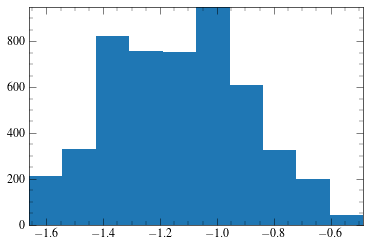

In [13]:
plt.hist(data[0]['w'])

0.0 [2.23422932] 17.021834457628433 5


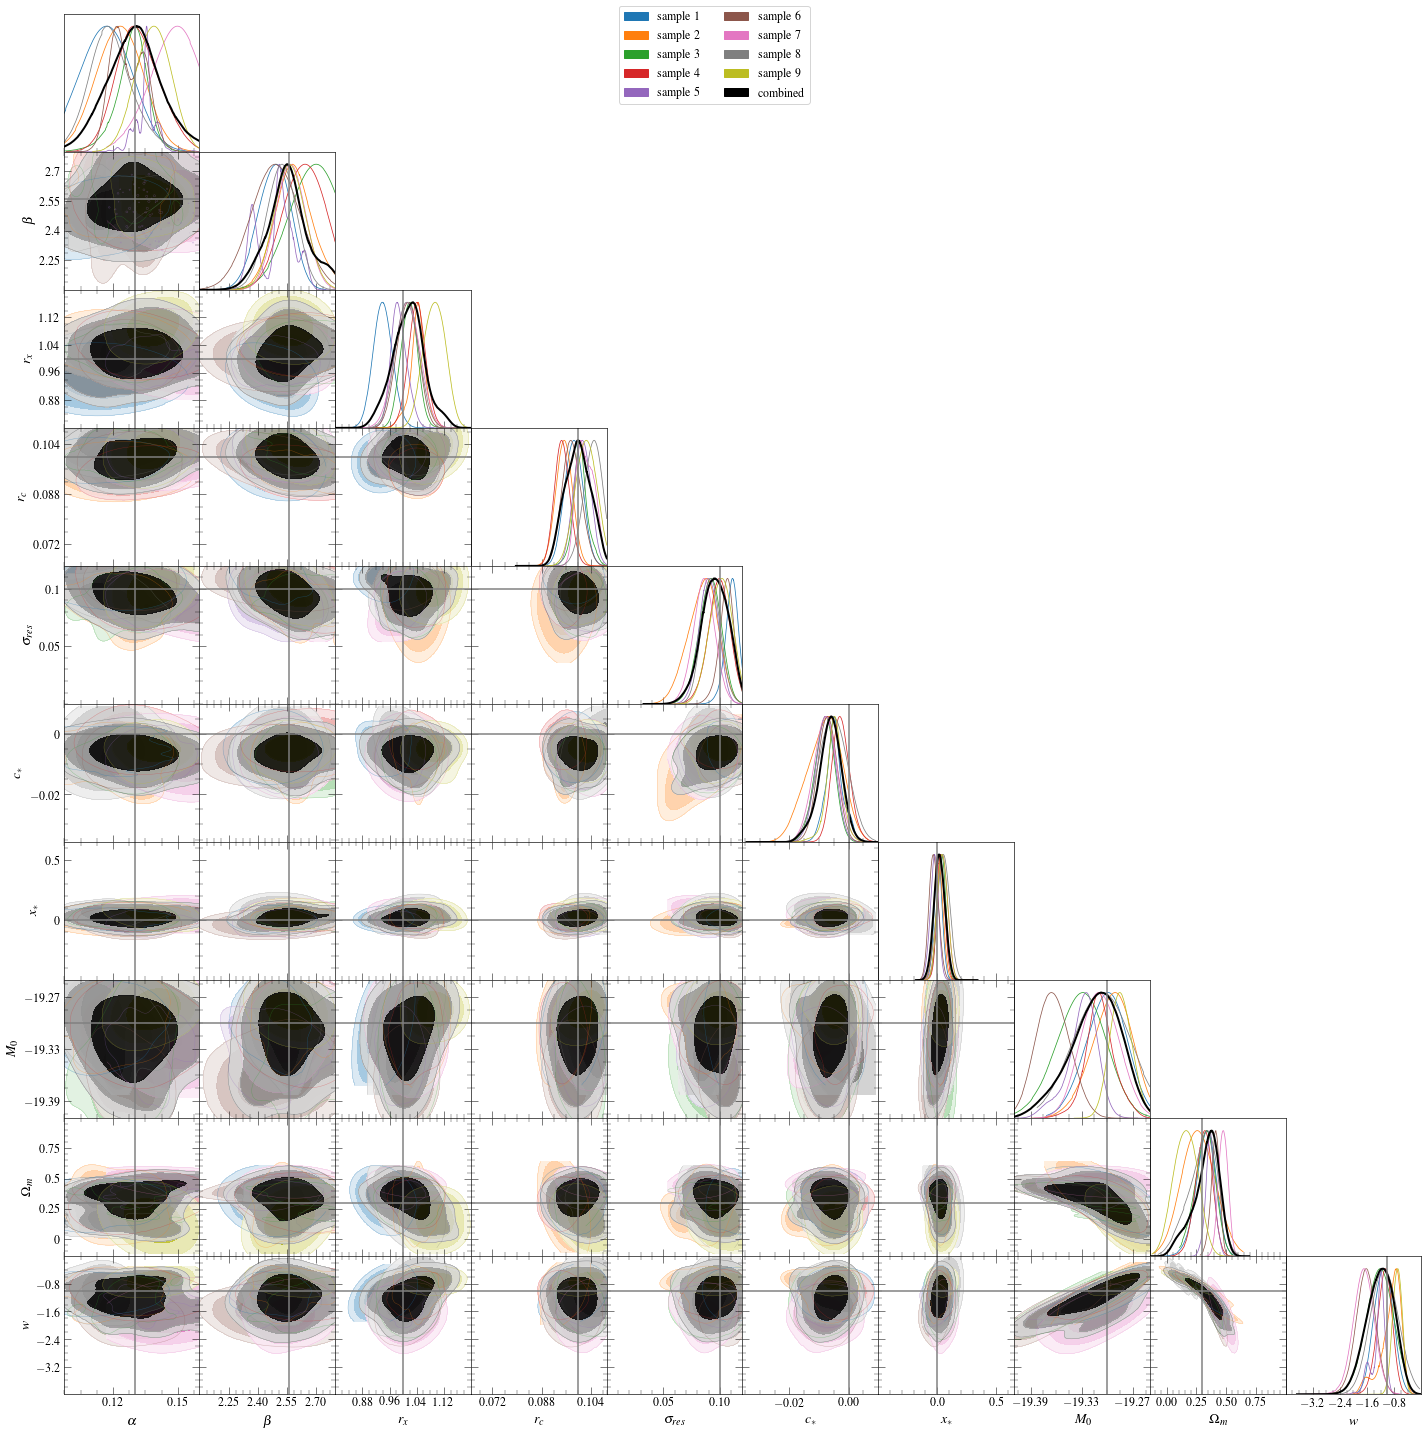

In [38]:
plt.style.use('./MNRAS_Style.mplstyle')
plotter = pt.getSubplotPlotter()
plotter.settings.num_plot_contours = 3
plotter.settings.rcSizes(12, 14, 12)

try:
    plotter.triangle_plot(mcsamples, filled=True, 
                      legend_labels=legend_labels, legend_ncol=2,
                      contour_args=contour_args, line_args=line_args,
                      param_limits=param_plot_limits)
except np.linalg.LinAlgError:
        pass

# draw true value lines
for i in range(len(plotter.subplots)):
    for j in range(len(plotter.subplots[i])):
        subplot = plotter.subplots[i][j]
        if subplot is not None:
            if i > j: # only draw horizontal line for 2D plots
                subplot.axhline(param_true_values[params_of_interest[i]], color='gray')
            subplot.axvline(param_true_values[params_of_interest[j]], color='gray')
plt.savefig('/c/Users/lucas/Documents/Imperial/writeup/plots/wcdm/reweighted_wcdm_arr_{}.pdf'.format(job_id), dpi='figure')
plt.show()


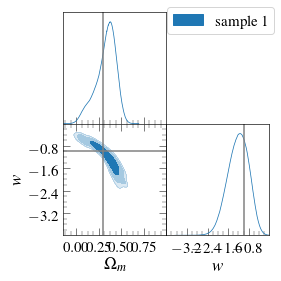

In [129]:
cosmo_params = ['omegam', 'w']
plt.style.use('./MNRAS_Style.mplstyle')
plotter = pt.getSubplotPlotter()
plotter.settings.num_plot_contours = 3
plotter.settings.rcSizes(15, 17, 15)

try:
    plotter.triangle_plot(cosmo, filled=True, 
                      legend_labels=legend_labels, legend_ncol=2,
                      contour_args=contour_args, line_args=line_args,
                      param_limits=param_plot_limits)
except np.linalg.LinAlgError:
        pass

# draw true value lines
for i in range(len(plotter.subplots)):
    for j in range(len(plotter.subplots[i])):
        subplot = plotter.subplots[i][j]
        if subplot is not None:
            if i > j: # only draw horizontal line for 2D plots
                subplot.axhline(param_true_values[cosmo_params[i]], color='gray')
            subplot.axvline(param_true_values[cosmo_params[j]], color='gray')
#plt.savefig('/rds/general/user/tmakinen/home/jobs/plots/reweighted_wcdm_arr_{}.png'.format(job_id), dpi='figure')
plt.show()


In [28]:
OmM = pd.concat(data)['omegam'].values
w_chain = pd.concat(data)['w'].values

In [29]:
weight = pd.concat(weight_arr)['easy'].values

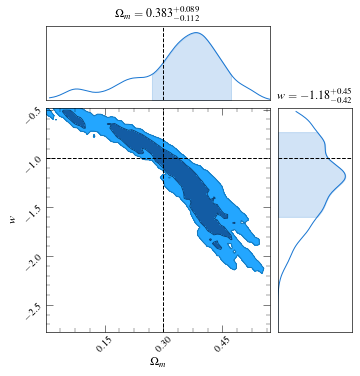

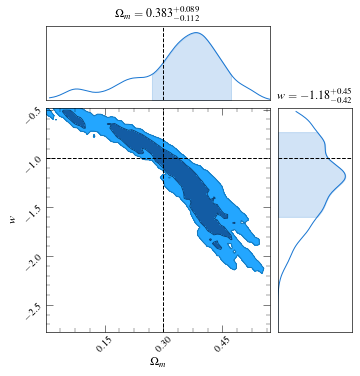

In [35]:
display_dat = [pd.concat(data)['omegam'].values, pd.concat(data)['w'].values]
c = ChainConsumer()
mean = [0.3, -1.0]
#c.add_chain(display_dat, parameters=["$\Omega_m$", "$w$"], name=r'Na\"ive')
c.add_chain(display_dat, parameters=["$\Omega_m$", "$w$"], weights=weight, name='Reweighted')
c.configure(kde=[True], flip=True)
#fig = c.plotter.plot(extents=[(-2, 4), (0, 9)])
c.plotter.plot(filename='/c/Users/lucas/Documents/Imperial/writeup/plots/reweighted_cosmo_wcdm.pdf'.format(job_id), figsize="column", truth=mean)

In [32]:
latexify()

KeyError: 'text.fontsize is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'

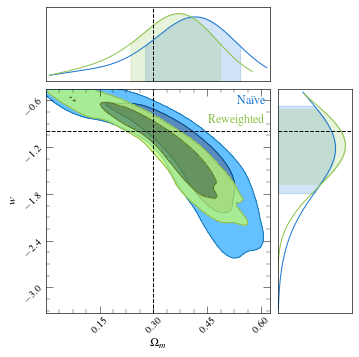

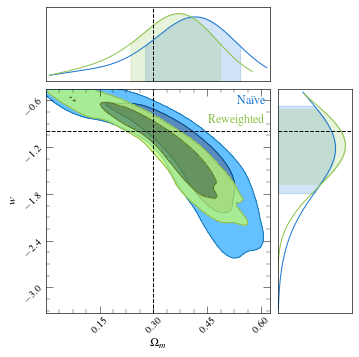

In [39]:
display_dat = [pd.concat(data)['omegam'].values, pd.concat(data)['w'].values]
c = ChainConsumer()
mean = [0.3, -1.0]
c.add_chain(display_dat, parameters=["$\Omega_m$", "$w$"], name=r'Na\"ive')
c.add_chain(display_dat, parameters=["$\Omega_m$", "$w$"], weights=weight, name='Reweighted')
c.configure(kde=[3.0, 3.0], flip=True)
#fig = c.plotter.plot(extents=[(-2, 4), (0, 9)])
c.plotter.plot(filename='/c/Users/lucas/Documents/Imperial/writeup/plots/wcdm/reweighted_comp_cosmo_wcdm.pdf', figsize="column", truth=mean)

# effective sample size metric

In [41]:
import effective_sample_size as sample_size

ess_pars = ['alpha', 'beta', 'omegam', 'w']


for param in ess_pars:
    for i in range(len(data)):
        ess = []
        param_vec = data[i][param].values
        ess.append((sample_size.effectiveSampleSize(param_vec)))
    ess = np.mean(ess)
    print('averaged ESS for {}: '.format(param) + '{0:8.3f}'.format(ess))

averaged ESS for alpha:   93.180
averaged ESS for beta:   38.146
averaged ESS for omegam:   50.944
averaged ESS for w:   57.803


# importance sampling to remove bias

In [18]:
len(D[7000::10])

300

In [19]:
import cosmology, latent_plots

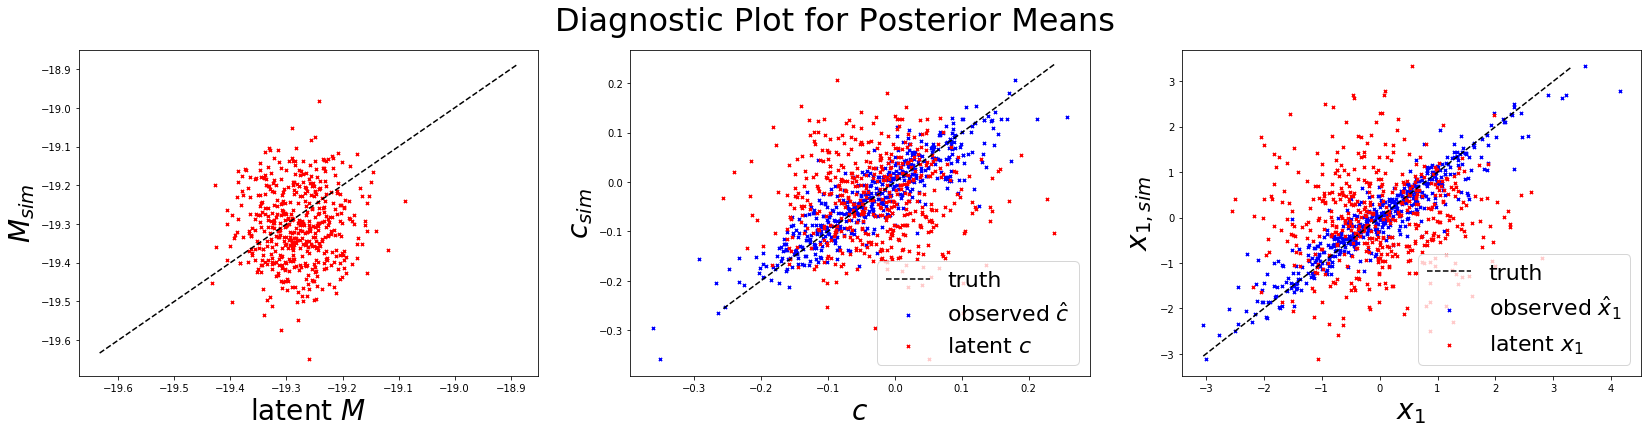

In [20]:
latent_plots.plot_post_means(D[7000::10], '/rds/general/user/tmakinen/home/jobs/gibbs_latent3/{}[{}].pbs/data/lc_params.txt'.format(job_id, 8))

In [6]:
job_id = 463806

In [19]:
# aggregate the latent vectors together
diagnostic = []
for i in range(n_sims):
    #if i+1 in [1,2,6]:
    #data_i = pd.read_csv('/rds/general/user/tmakinen/home/WORK/{}[{}].pbs/post_chains.csv'.format(job_id, i+1), sep=",", header=None)
    diag_i = pd.read_csv('/rds/general/user/tmakinen/home/jobs/long_gibbs/{}[{}].pbs/gibbs_chains/D_latent.csv'.format(job_id, i+1), sep=",", header=None)
    diagnostic.append(diag_i[8000::])

In [20]:
datafnames = ['/rds/general/user/tmakinen/home/jobs/long_gibbs/{}[{}].pbs/sel_lcparams.txt'.format(job_id, i+1) for i in range(n_sims)]

In [21]:
weight_arr[0]['norm'].values

array([2.06637607e-05, 1.16927872e-05, 1.59732088e-04, ...,
       4.61467021e-08, 4.83343170e-06, 3.17922032e-07])

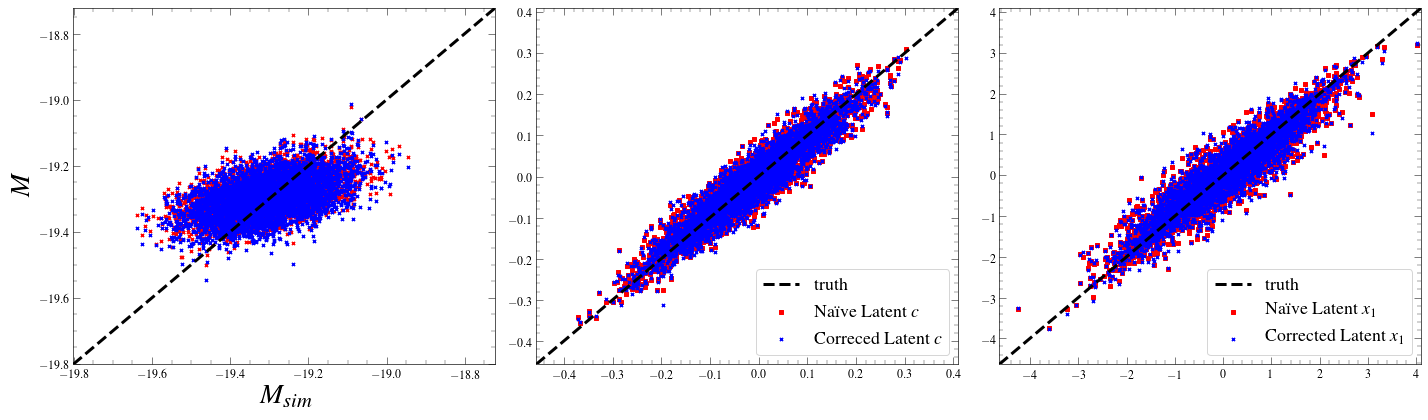

In [65]:
import cosmology
plt.style.use('./MNRAS_Style.mplstyle')

M_true = []

mb_true = []
c_true = []
x1_true = []
z = []

m_means = []
c_means = []
x_means = []
    
m_means_reweighted = []
c_means_reweighted = []
x_means_reweighted = []

# make 1 x 3 diagnostic scatter plot for M, c, x1
fig,(ax0,ax1,ax2) = plt.subplots(1, 3, figsize = (20,6))
#plt.suptitle('Posterior Representation for 10 Selection Effects Inferences', fontsize=32)
for i in range(len(diagnostic)):

    D_chain = diagnostic[i]
    datafname = datafnames[i]

    
    columns = D_chain.columns
    
    w_i = weight_arr[i]['norm'].values
        

    for j in range(len(columns)):
        if j % 3 == 0:
            m_means.append(np.mean(D_chain[columns[j+2]]))
            c_means.append(np.mean(D_chain[columns[j]]))
            x_means.append(np.mean(D_chain[columns[j+1]]))
            
            #w_i = weight_arr[i]['easy'].values
            
            m_means_reweighted.append(np.average(D_chain[columns[j+2]], weights=w_i))
            c_means_reweighted.append(np.average(D_chain[columns[j]], weights=w_i))
            x_means_reweighted.append(np.average(D_chain[columns[j+1]], weights=w_i))

    # compare to JLA-like sims -- take only every 10th snia
    data = pd.read_csv(datafname, sep='\s+', header=0)

    ndat = len(data)
    Zhel = data['z'].values
    zHD = data['z'].values
    # add second z column so that we have a zHD value
    data.insert(loc=1, column='zHD', value=zHD)
    Zcmb = data['z'].values
    
    z.append(data['z'].values)

    # unpack data values
    mb_true.append(data['true_mb'].values)
    c_true.append(data['true_c'].values)
    x1_true.append(data['true_x1'].values)

    # compute true residual
    a_true = 0.13
    b_true = 2.56
    cosmo_param = [0.3, 0.7, 0.72]              # true simulated params
    mu = cosmology.muz(cosmo_param, Zcmb, Zhel) # distance modulus

    M = []

    for i in range(ndat):
        M.append(data['true_mb'].values[i] - mu[i] + a_true*data['true_x1'].values[i] - b_true*data['true_c'].values[i])
    
    M_true.append(M)



    

    #ax0.legend(fontsize = 22, loc='upper left')
    # observed c vs simulated c
    #ax1.scatter(c_true, data['c'].values,  
                    #color = 'b', marker = 'x', s=10)
    
    # latent c vs simulated c
    #ax1.scatter(c_true, c_means,  color = 'r', 
                    #marker = 'x', s=10)
    
    # corrected latent c vs sim c
    #ax1.scatter(c_true, c_means_reweighted,  color = 'b', 
                    #marker = 'x', s=10)

    #ax1.set_ylabel('$c$', fontsize=28)
    #ax1.set_xlabel('$c_{sim}$', fontsize=28)
    #if i == n_sims-1:

    # latent x1
    #ax2.scatter(x1_true, data['x1'].values, 
                    #color = 'b', marker = 'x', s=10)
    #ax2.scatter(x1_true, x_means,  
                    #color = 'r', marker = 'x', s=10)
    
    # corrected x1
    #ax2.scatter(x1_true, x_means_reweighted,  
                    #color = 'b', marker = 'x', s=10)


    #ax2.set_ylabel('$x_1$', fontsize=28)
    #ax2.set_xlabel('$x_{1,sim}$', fontsize=28)
    
    
# plot last ones again for label's sake:
x = np.linspace(start=min(m_means)-0.3, stop = max(m_means)+0.3, num=50)
y = np.linspace(start=min(m_means)-0.3, stop = max(m_means)+0.3, num=50)
ax0.plot(x,y, linestyle='--', color='k', label='truth', linewidth=3)
ax0.set_ylabel('$M$', fontsize=28)
ax0.set_xlabel('$M_{sim}$', fontsize=28)

# plot M vs M_true
ax0.scatter(np.array(M_true), np.array(m_means), 
                            color='r', marker = 'x', s=10)
# plot M reweighted vs M_true
ax0.scatter(np.array(M_true), np.array(m_means_reweighted), 
                            color='b', marker = 'x', s=10)

# ax1
#ax1.scatter(c_true, data['c'].values, 
                    #color = 'b', marker = 's', s=10, label='Observed $\hat{c}$')
# latent c vs simulated c
ax1.scatter(c_true, c_means,  color = 'r', 
                    marker = 's', s=10, label=r'Na\"ive Latent $c$')
# corrected latent c vs sim c
ax1.scatter(c_true, c_means_reweighted,  color = 'b', 
                    marker = 'x', s=10, label='Correced Latent $c$')

x = np.linspace(start=min(c_means)-0.1, stop=max(c_means)+0.1, num=50)
y = np.linspace(start=min(c_means)-0.1, stop=max(c_means)+0.1, num=50)
ax1.plot(x,y, linestyle='--', color='k', label='truth', linewidth=3)  # plot truth line
ax1.legend(fontsize = 18, loc='lower right')

# ax2
#ax2.scatter(x1_true, data['x1'].values,  
                    #color = 'b', marker = 's', s=10, label='Observed $\hat{x}_1$')
ax2.scatter(x1_true, x_means,  
                    color = 'r', marker = 's', s=10, label=r'Na\"ive Latent $x_1$')

ax2.scatter(x1_true, x_means_reweighted,  
                    color = 'b', marker = 'x', s=10, label='Corrected Latent $x_1$')

x = np.linspace(start=min(x_means)-0.9, stop=max(x_means)+0.9, num=50)
y = np.linspace(start=min(x_means)-0.9, stop=max(x_means)+0.9, num=50)
ax2.plot(x,y, linestyle='--', color='k', label='truth', linewidth=3)  # plot truth line
ax2.legend(fontsize = 18, loc='lower right')
plt.tight_layout()
#plt.savefig(fname='/rds/general/user/tmakinen/home/jobs/plots/{}_van_on_sel_aggregate_posterior_diagnostic1.png'.format(job_id),rasterized=True, dpi='figure')
plt.show()



In [85]:
val = np.array(m_means) - x

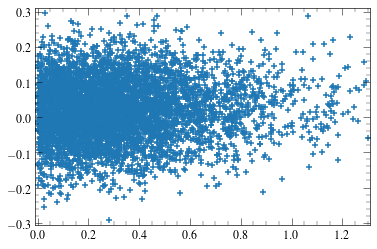

In [92]:
# plot msim - m by redshift
datafnames = ['/rds/general/user/tmakinen/home/jobs/long_gibbs/{}[{}].pbs/sel_lcparams.txt'.format(job_id, i+1) for i in range(n_sims)]
latentfnames = datafnames = ['/rds/general/user/tmakinen/home/jobs/long_gibbs/{}[{}].pbs/lc_params.txt'.format(job_id, i+1) for i in range(n_sims)]
    
datafname = datafnames[4]
latentname = latentfnames[4]

dats = [datafname, latentname]
    
for name in range(len(dats)):
    data = pd.read_csv(name, sep='\s+', header=0)

    ndat = len(data)
    Zhel = data['z'].values
    zHD = data['z'].values
    # add second z column so that we have a zHD value
    data.insert(loc=1, column='zHD', value=zHD)
    Zcmb = data['z'].values
    
    z.append(data['z'].values)

    # unpack data values
    mb_true = (data['true_mb'].values)
    c_true = (data['true_c'].values)
    x1_true = (data['true_x1'].values)

    # compute true residual
    a_true = 0.13
    b_true = 2.56
    cosmo_param = [0.3, 0.7, 0.72]              # true simulated params
    mu = cosmology.muz(cosmo_param, Zcmb, Zhel) # distance modulus

    M = []

    for i in range(ndat):
        M.append(data['true_mb'].values[i] - mu[i] + a_true*data['true_x1'].values[i] - b_true*data['true_c'].values[i])



x = [j for l in M_true for j in l]
x = np.array(x)
z_plot = [i for k in z for i in k]

plt.scatter(z_plot, val, marker='+')

In [75]:
m_plot.shape

(5000,)

In [40]:
# plot contours of ellipses
for m_var in [m_means, m_means_reweighted]:
    x = M_true
    y = m_var
    cov = np.cov(x, y)
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    from matplotlib.patches import Ellipse
    ax = plt.subplot(111, aspect='equal')
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=lambda_[0]*2, height=lambda_[1]*2,
                  angle=np.rad2deg(np.arccos(v[0, 0])))
    ell.set_facecolor('none')
    ax.add_artist(ell)
    plt.scatter(x, y)
    plt.show()

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [51]:
len(x)

10

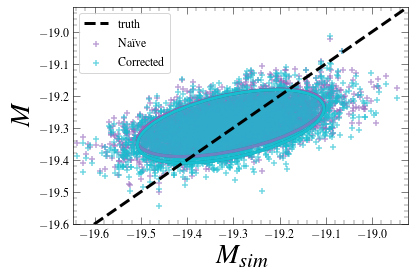

In [64]:
from matplotlib.patches import Ellipse
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

colors = ['#9467bd','#17becf']
labels = [r'Na\"ive', 'Corrected']

ax = plt.subplot(111)
varbs = [m_means, m_means_reweighted]
for i in range(len(varbs)):
    x = [j for l in M_true for j in l]
    y = varbs[i]

    nstd = 2


    cov = np.cov(x, y)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
              width=w, height=h,
              angle=theta, color='k', linewidth=3)
    ell.set_facecolor(colors[i])
    ell.set_alpha(0.3)
    ax.add_artist(ell)
    
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
              width=w, height=h,
              angle=theta, color=colors[i], linewidth=3)
    ax.add_artist(ell)
    ell.set_facecolor('None')
    

    
    
    plt.scatter(x, y, marker='+', alpha=0.6, color = colors[i], label=labels[i])
    
#= plot truth line
    
x = np.linspace(start=min(m_means)-0.1, stop = max(m_means)+0.1, num=50)
y = np.linspace(start=min(m_means)-0.1, stop = max(m_means)+0.1, num=50)
ax.plot(x,y, linestyle='--', color='k', label='truth', linewidth=3)

ax.set_ylabel('$M$', fontsize=28)
ax.set_xlabel('$M_{sim}$', fontsize=28)
plt.legend()
plt.savefig('/rds/general/user/tmakinen/home/jobs/plots/{}_M_corrected.png'.format(job_id), rasterized=True, dpi='figure')

plt.show()

In [56]:
len(x)

10

In [58]:
D = pd.read_csv('/rds/general/user/tmakinen/home/jobs/gibbs_latent3/{}[{}].pbs/gibbs_chains/D_latent.csv'.format(job_id, 3), sep=",", header=None)

In [84]:
print(np.mean(c_true))

-0.011652073781778944


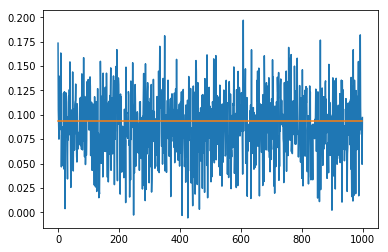

In [59]:
jla_dat = pd.read_csv('/rds/general/user/tmakinen/home/jobs/gibbs_latent3/{}[{}].pbs/data/lc_params.txt'.format(job_id, 3), sep="\s+", header=0)
point = jla_dat['true_c'][0]
plt.plot(np.arange(start=0, stop=len(D[0][::10])), D[0].values[::10])
plt.plot(np.arange(start=0, stop=len(D[0][::10])), np.ones(len(D[0][::10]))*point)
plt.show()

In [80]:
param_list = ['true_c', 'true_x1', 'M_true']
label_list = ['c', 'x1', 'M']
D = pd.read_csv('/rds/general/user/tmakinen/home/jobs/long_gibbs/{}[{}].pbs/gibbs_chains/D_latent.csv'.format(job_id, 3), sep=",", header=None)
jla_dat = pd.read_csv('/rds/general/user/tmakinen/home/jobs/long_gibbs/{}[{}].pbs/sel_lcparams.txt'.format(job_id, 3), sep="\s+", header=0)

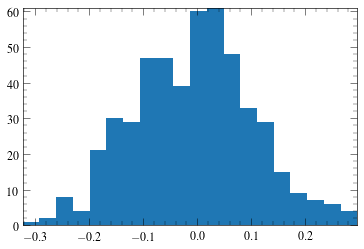

0.10955336471927059
-0.006938633598715301


In [83]:
plt.hist(jla_dat['c'], bins=20)
plt.show()
print(np.std(jla_dat['c']))
print(np.mean(jla_dat['c']))

In [156]:
# plot the true JLA data that we drew our latent values from
datafnames = ['/rds/general/user/tmakinen/home/jobs/gibbs_latent3/{}[{}].pbs/data/jla_lcparams.txt'.format(job_id, i+1) for i in range(n_sims)]
jla_dat = []
for i in range(n_sims):
    jla_dat.append(pd.read_csv(datafnames[i], sep='\s+', header=0))
jla_dat = pd.concat(jla_dat, axis=0)

true jla population color mean:  -0.023862447297297296
true jla population color spread:  0.08405487210573868


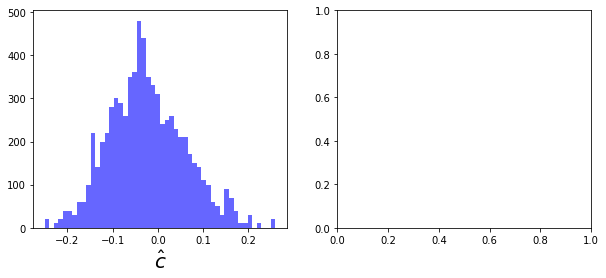

In [158]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(jla_dat['color'], color='b', alpha=0.6, bins=50)
#ax1.hist(jla_dat['true_c'], color='r', alpha=0.6, bins=50)
#ax1.title('True Simulated Color Distribution for 5000 SN1a', fontsize=20)
ax1.set_xlabel(r'$\hat{c}$', fontsize=20)


#ax2.hist(jla_dat['true_c'], color='r', alpha=0.6, bins=50)
#ax2.set_xlabel(r'true $c$', fontsize=20)
print('true jla population color mean: ', np.mean(jla_dat['color']))
print('true jla population color spread: ', np.std(jla_dat['color']))

In [130]:
# compute true residual
Zhel = jla_dat['z'].values
zHD = jla_dat['z'].values
    # add second z column so that we have a zHD value
jla_dat.insert(loc=1, column='zHD', value=zHD)
Zcmb = jla_dat['z'].values

# unpack data values
mb_true = jla_dat['true_mb'].values
c_true = jla_dat['true_c'].values
x1_true = jla_dat['true_x1'].values

# compute true residual
a_true = 0.13
b_true = 2.56
cosmo_param = [0.3, 0.7, 0.72]              # true simulated params
mu = cosmology.muz(cosmo_param, Zcmb, Zhel) # distance modulus
M_true = []


for i in range(ndat):
    M_true.append(mb_true[i] - mu[i] + a_true*x1_true[i] - b_true*c_true[i])

jla_dat.insert(loc=1, column='M_true', value=M_true)

In [137]:
import os

In [145]:
# repeat for 10 random SNIa
for k in range(10):
    randnum = int(np.random.rand()*500)
    # the random data
    for i in range(3):
        os.makedirs('{}_latent'.format(label_list[i]),exist_ok=True)
        j = randnum*3  # params stored in sets of 3
        point = jla_dat[param_list[i]][randnum]  # truth
        x = np.arange(start=0, stop=len(D[j+i][::10]))
        y = D[j+i].values[::10]

        nullfmt = plt.NullFormatter()         # no labels

        # definitions for the axes
        left, width = 0.1, 0.65
        bottom, height = 0.1, 0.65
        bottom_h = left_h = left + width + 0.02

        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom_h, width, 0.2]
        rect_histy = [left_h, bottom, 0.2, height]

        # start with a rectangular Figure
        plt.figure(3, figsize=(9, 5))

        axScatter = plt.axes(rect_scatter)
        #axHistx = plt.axes(rect_histx)
        axHisty = plt.axes(rect_histy)

        # no labels
        #axHistx.xaxis.set_major_formatter(nullfmt)
        axHisty.yaxis.set_major_formatter(nullfmt)

        # the scatter plot:

        uplim = 28                         # set upper and lower limits for color bar (+3 std dev)
        lowlim = 17 

        sctrac = axScatter.plot(x, y, color=colors[i], alpha=0.6, label=label_list[i] + ' Posterior Chain')

        axScatter.plot(np.arange(start=0, stop=len(D[j+i][::10])), np.ones(len(D[j+i][::10]))*point, color='k', label='Simulated truth')

        # now determine nice limits by hand:
        binwidth = 0.5
        xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
        lim = (int(xymax/binwidth) + 1) * binwidth

    #axScatter.set_xlim((-lim, lim))
    #axScatter.set_ylim((-lim, lim))

    #axScatter.set_xlim((17, 25))
    #axScatter.set_ylim((-2, 3))

        bins = np.arange(-lim, lim + binwidth, binwidth)

        axHisty.hist(y, bins=60, color=colors[i], normed=False, orientation='horizontal', alpha=0.6)
    #axHisty.hist(y[hsc], bins=15, color='b', alpha=0.6, normed=False, orientation='horizontal')

    #axHistx.set_xlim(axScatter.get_xlim())
        axHisty.set_ylim(axScatter.get_ylim())

    #axHistx.set_ylabel('Count', fontsize=10)
    #axHisty.set_xlabel('Count', fontsize=10)

        axScatter.set_xlabel(r'$t /10$', fontsize = 17)
        axScatter.set_ylabel('${}$'.format(label_list[i]),fontsize=17)
        axScatter.legend(loc='best')
        plt.savefig('/rds/general/user/tmakinen/home/jobs/gibbs_latent3/{}_latent/snia_{}'.format(label_list[i], randnum), dpi='figure')
        plt.close()

In [14]:
# get performance stats
stat_fnames = ['/rds/general/user/tmakinen/home/jobs/gibbs_latent3/{}[{}].pbs/gibbs_chains/sampler_stats.csv'.format(job_id, i+1) for i in range(n_sims)]

In [15]:
colnm = [r'$\mathscr{C}$ acceptance fraction', r'$\mathscr{B}$ acceptance fraction', 'runtime (hrs)']

In [16]:
stat_tab = []
for name in stat_fnames:
    stt = pd.read_csv(name, sep=',', header=None)
    stt.columns = colnm
    stat_tab.append(stt)
stat_tab = pd.concat(stat_tab, axis=0)
#stat_tab.rename(index=)

In [17]:
stat_tab.index = [i+1 for i in range(10)]

In [19]:
stat_tab['runtime (hrs)'] = stat_tab['runtime (hrs)'] / 60 / 60

# $\mathscr{C}\ = \{ \Omega_m, \Omega_{de} \} \sim \mathscr{MH}(\mathscr{C} | \mathscr{\hat{D}}, \Sigma_D', \mathscr{B}')$
# $\mathscr{B}\ = \{ \alpha, \beta \} \sim \mathscr{MH}(\mathscr{C} | \mathscr{\hat{D}}, \Sigma_D', \mathscr{B})$

In [20]:
stat_tab

,$\mathscr{C}$ acceptance fraction,$\mathscr{B}$ acceptance fraction,runtime (hrs)
1,0.2619,0.1173,8.973991
2,0.2151,0.3590,17.023914
3,0.2898,0.1684,17.043342
4,0.2234,0.1760,14.866390
5,0.3055,0.1321,8.963554
6,0.3323,0.0366,10.441058
7,0.2428,0.1272,8.998381
8,0.2918,0.4403,10.526921
9,0.3637,0.1636,10.552602
10,0.3350,0.2396,10.457072


##                 Importance Sampling
# $\textbf{E}[f] = \int{}{}f(\vec{\textbf{x}})\ {p}(\vec{\textbf{x}}) d\vec{x} = \int{}{}f(\vec{\textbf{x}}) \frac{\tilde{p}(\vec{\textbf{x}})}{\tilde{q}(\vec{\textbf{x}})} \tilde{q}(\vec{\textbf{x}})$
## For Discrete Case over s=1,...,S posterior points: 
# $ \approx \frac{1}{S} \sum_{s=1}^{S} w_s f(\vec{x}^s)$

# where $ w_s := \frac{p(\vec{x^s})}{q(\vec{x^s})} = \frac{\mathscr{L_{{corr}}}}{\mathscr{L}_{vanilla}} $

# normalized weights $ w_s := \frac{\tilde{p}(\vec{x^s})\ /\ \tilde{q}(\vec{x^s})}{\sum_{m=1}^{M}\tilde{p}(\vec{x^m})\ /\ \tilde{q}(\vec{x^m})} $

# where 
# $ {p}(\vec{x^s}) = \frac{1}{N_p} \tilde{p}(\vec{x^s})   $
# $ {q}(\vec{x^s}) = \frac{1}{N_q} \tilde{q}(\vec{x^s}) $

# $ \sigma_{err} = \frac{\langle bias \rangle}{\sqrt{\sigma_{bias}^2 + \sigma_{means}^2}}$